# Passive Learning Curve

In this notebook, I will train logistic regression for different amounts of training data and plot the resulting accuracy on the Norris et al. labels.

In [29]:
import sys

import h5py, numpy, sklearn.neighbors
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

sys.path.insert(1, '..')
import crowdastro.train, crowdastro.test

TRAINING_H5_PATH = '../training.h5'
CROWDASTRO_H5_PATH = '../crowdastro.h5'
NORRIS_DAT_PATH = '../data/norris_2006_atlas_classifications_ra_dec_only.dat'
CLASSIFIER_OUT_PATH = '../classifier.pkl'
ASTRO_TRANSFORMER_OUT_PATH = '../astro_transformer.pkl'
IMAGE_TRANSFORMER_OUT_PATH = '../image_transformer.pkl'
IMAGE_SIZE = 200 * 200
ARCMIN = 1 / 60
N_JOBS = 8

%matplotlib inline

In [20]:
# Load labels.
with h5py.File(TRAINING_H5_PATH, 'r') as training_h5:
    crowdsourced_labels = training_h5['labels'].value

with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    ir_names = crowdastro_h5['/wise/cdfs/string'].value
    ir_positions = crowdastro_h5['/wise/cdfs/numeric'].value[:, :2]
ir_tree = sklearn.neighbors.KDTree(ir_positions)

with open(NORRIS_DAT_PATH, 'r') as norris_dat:
    norris_coords = [r.strip().split('|') for r in norris_dat]

norris_labels = numpy.zeros((len(ir_positions)))
for ra, dec in norris_coords:
    # Find a neighbour.
    skycoord = SkyCoord(ra=ra, dec=dec, unit=('hourangle', 'deg'))
    ra = skycoord.ra.degree
    dec = skycoord.dec.degree
    ((dist,),), ((ir,),) = ir_tree.query([(ra, dec)])
    if dist < 0.1:
        norris_labels[ir] = 1

In [41]:
def train_and_test(fraction):
    with h5py.File(TRAINING_H5_PATH, 'r') as training_h5, h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
        n_static = 5 if training_h5.attrs['ir_survey'] == 'wise' else 6
        train_indices = training_h5['is_ir_train'].value
        
        # Downsample training indices to match the fraction.
        # This effectively means regenerating the training indices.
        # Start by downsampling the ATLAS training indices.
        atlas_train_indices = training_h5['is_atlas_train'].value.nonzero()[0]
        n_indices = len(atlas_train_indices)
        numpy.random.shuffle(atlas_train_indices)
        atlas_not_train_indices = atlas_train_indices[int(n_indices * fraction):]
        # Remove all IR objects near removed ATLAS objects.
        for atlas_index in atlas_not_train_indices:
            ir = crowdastro_h5['/atlas/cdfs/numeric'][atlas_index, n_static + IMAGE_SIZE:]
            nearby = (ir < ARCMIN).nonzero()[0]
            for ir_index in nearby:
                train_indices[ir_index] = 0
        
        # We can now proceed as usual with training/testing.

        outputs = training_h5['labels'].value[train_indices]
        n = len(outputs)

        astro_inputs = numpy.minimum(
                training_h5['features'][train_indices, :n_static], 1500)
        image_inputs = training_h5['features'].value[train_indices, n_static:]

        astro_transformer = sklearn.pipeline.Pipeline([
                ('normalise', sklearn.preprocessing.Normalizer()),
                ('scale', sklearn.preprocessing.StandardScaler()),
        ])
        image_transformer = sklearn.pipeline.Pipeline([
                ('normalise', sklearn.preprocessing.Normalizer()),
        ])

        features = []
        features.append(astro_transformer.fit_transform(astro_inputs))
        features.append(image_transformer.fit_transform(image_inputs))
        inputs = numpy.hstack(features)

        classifier = sklearn.linear_model.LogisticRegression(
                class_weight='balanced', n_jobs=N_JOBS)
        classifier.fit(inputs, outputs)

        test_indices = training_h5['is_atlas_test'].value
        numeric_subjects = crowdastro_h5['/atlas/cdfs/numeric'][test_indices, :]

        n_norris_agree = 0
        n_crowdsourced_agree = 0
        n_all_agree = 0
        n_either_agree = 0
        n_no_host = 0
        n_total = 0
        for subject in numeric_subjects:
            swire = subject[2 + IMAGE_SIZE:]
            nearby = swire < ARCMIN
            astro_inputs = numpy.minimum(training_h5['features'][nearby, :n_static],
                                         1500)
            image_inputs = training_h5['features'][nearby, n_static:]

            features = []
            features.append(astro_transformer.transform(astro_inputs))
            features.append(image_transformer.transform(image_inputs))
            inputs = numpy.hstack(features)

            crowdsourced_outputs = crowdsourced_labels[nearby]
            norris_outputs = norris_labels[nearby]

            if sum(crowdsourced_outputs) < 1 or sum(norris_outputs) < 1:
                # No hosts!
                n_no_host += 1
                continue

            selection = classifier.predict_proba(inputs)[:, 1].argmax()
            n_norris_agree += norris_outputs[selection]
            n_crowdsourced_agree += crowdsourced_outputs[selection]
            n_all_agree += norris_outputs[selection] * crowdsourced_outputs[selection]
            n_either_agree += norris_outputs[selection] or crowdsourced_outputs[selection]
            n_total += 1
    return (n_norris_agree / n_total, n_crowdsourced_agree / n_total,
            n_all_agree / n_total, n_either_agree / n_total)

In [42]:
fractions = numpy.linspace(0.05, 1.0, 20)
results = numpy.array([train_and_test(f) for f in fractions])

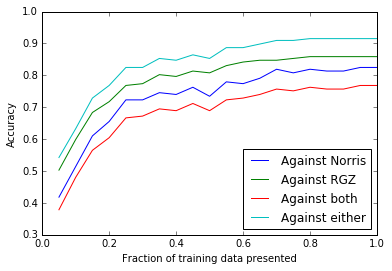

In [43]:
plt.plot(fractions, results[:, 0])
plt.plot(fractions, results[:, 1])
plt.plot(fractions, results[:, 2])
plt.plot(fractions, results[:, 3])
plt.xlabel('Fraction of training data presented')
plt.ylabel('Accuracy')
plt.legend(['Against Norris', 'Against RGZ', 'Against both', 'Against either'], loc='lower right')